## Factor Investing Project
Sep 2025 - Parimah 

import and setting

In [21]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from src.data_loader import get_sp500_tickers, download_price_data, get_fundamentals
from src.factor_builder import compute_momentum, compute_quality_from_vol, cross_sectional_zscore, value_from_fundamentals, combine_factors
from src.portfolio import construct_long_short_weights, expand_weights_to_daily
from src.backtest import backtest, performance_stats, rolling_sharpe

plt.style.use('classic')  ###


tickers and prices

In [25]:
tickers = get_sp500_tickers()[:200]   # use fewer tickers for faster iterations; swap to full list later
prices = download_price_data(tickers, start="2010-01-01", end="2025-01-01")
prices = prices.dropna(how='all', axis=1)  # drop tickers with no data
prices = prices.fillna(method='ffill').dropna(how='all')

# add SPY for market proxy
spy = yf.download('SPY', start='2015-01-01', end='2024-12-31')['Close']
prices['SPY'] = spy

prices.shape


/Users/Parimah/Desktop/factor-investing-backtest/src/data_loader.py:19: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(html)[0]
/Users/Parimah/Desktop/factor-investing-backtest/src/data_loader.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(batch, start=start, end=end, interval=interval, threads=True)['Close']


[*********************100%***********************]  80 of 80 completed


/Users/Parimah/Desktop/factor-investing-backtest/src/data_loader.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(batch, start=start, end=end, interval=interval, threads=True)['Close']
[*********************100%***********************]  80 of 80 completed
/Users/Parimah/Desktop/factor-investing-backtest/src/data_loader.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(batch, start=start, end=end, interval=interval, threads=True)['Close']
[                       0%                       ]

[*********************100%***********************]  40 of 40 completed
/var/folders/tm/r66jhs6d1dn78h8vczcd1wlm0000gn/T/ipykernel_9509/162183445.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices = prices.fillna(method='ffill').dropna(how='all')
/var/folders/tm/r66jhs6d1dn78h8vczcd1wlm0000gn/T/ipykernel_9509/162183445.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download('SPY', start='2015-01-01', end='2024-12-31')['Close']
[*********************100%***********************]  1 of 1 completed


(3774, 201)

compute factors

In [27]:
mom = compute_momentum(prices)          # DataFrame
quality = compute_quality_from_vol(prices)
# Optionally get fundamentals and build a value factor
funds = get_fundamentals(prices.columns.tolist())
val = value_from_fundamentals(funds)   # returns Series indexed by ticker

# convert val Series to DataFrame aligned to mom (broadcast to all dates)
val_df = pd.DataFrame([val.values] * len(mom.index), index=mom.index, columns=mom.columns)


/Users/Parimah/Desktop/factor-investing-backtest/src/factor_builder.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  mom = prices.pct_change(periods=lookback_days).shift(skip_days)
/Users/Parimah/Desktop/factor-investing-backtest/src/factor_builder.py:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_ret = prices.pct_change()


Z-score and Composite

In [28]:
mom_z = cross_sectional_zscore(mom)
quality_z = cross_sectional_zscore(quality)
val_z = cross_sectional_zscore(val_df)

factors = {'momentum': mom_z, 'quality': quality_z, 'value': val_z}
# equal weights (you can change)
composite = (mom_z + quality_z + val_z) / 3.0
# or use combine_factors if you prefer


Rebalance

In [30]:
# choose monthly rebalancing on month-ends
rebalance_dates = prices.resample('M').last().index
composite_reb = composite.reindex(rebalance_dates).dropna(how='all')
weights = construct_long_short_weights(composite_reb, long_pct=0.2, short_pct=0.2)
daily_weights = expand_weights_to_daily(weights, price_index=prices.index)



/var/folders/tm/r66jhs6d1dn78h8vczcd1wlm0000gn/T/ipykernel_9509/3817799507.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = prices.resample('M').last().index


Basket and Metrics

In [31]:
strategy_returns = backtest(daily_weights, prices)
stats, cumulative, drawdown = performance_stats(strategy_returns)
print(stats)


{'total_return': np.float64(-0.5927240326508283), 'ann_return': np.float64(-0.044270248615992124), 'ann_vol': np.float64(0.17631418277298774), 'sharpe': np.float64(-0.2510872802160902), 'max_drawdown': np.float64(-0.7595966414675202)}


/Users/Parimah/Desktop/factor-investing-backtest/src/backtest.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_ret = prices.pct_change().fillna(0)


Plots

/var/folders/tm/r66jhs6d1dn78h8vczcd1wlm0000gn/T/ipykernel_9509/4001036601.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  prices['SPY'].pct_change().fillna(0).add(1).cumprod().plot(ax=ax[0], label='SPY')  # if SPY downloaded


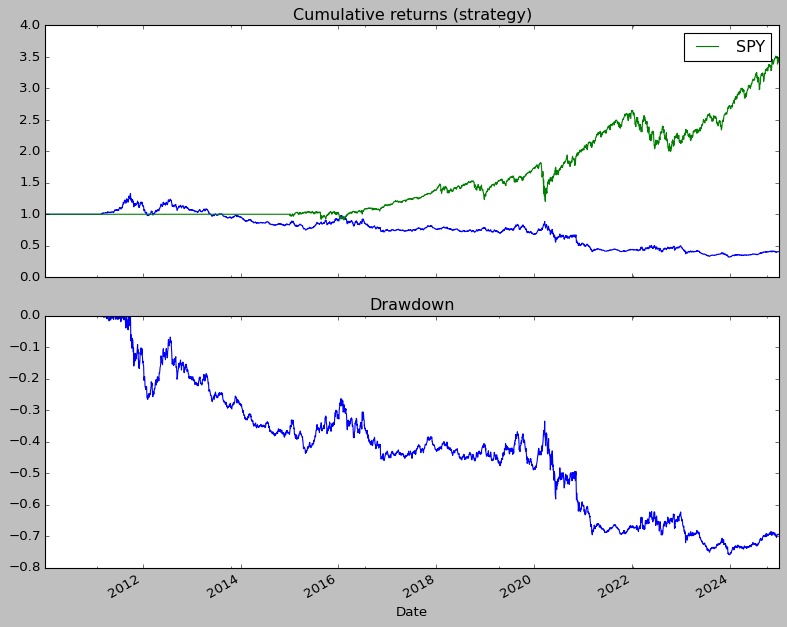

In [33]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
cumulative.plot(ax=ax[0], title='Cumulative returns (strategy)')
prices['SPY'].pct_change().fillna(0).add(1).cumprod().plot(ax=ax[0], label='SPY')  # if SPY downloaded
ax[0].legend()

drawdown.plot(ax=ax[1], title='Drawdown')
plt.tight_layout()
plt.show()


Transaction Costs and Turnover

In [18]:
# approximate turnover (daily)
turnover = daily_weights.diff().abs().sum(axis=1)  # total absolute weight change
cost_per_unit = 0.0005   # 0.05% per traded notional (example)
trade_costs = turnover * cost_per_unit
strategy_returns_net = strategy_returns.sub(trade_costs.shift(1).fillna(0))  # charge cost on rebalancing
